In [1200]:
# Packages
import pytesseract
from PIL import Image
from io import StringIO
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations
from scipy.stats import linregress
import math

In [1224]:
image_num = '4086'
full_image = 'UCD_Lehmann_'+image_num+'.jpg'

def tesseract_data(image):
    color_image = Image.open('/Users/tommylee/Desktop/STA 160/SampleCatalogPages/'+image)
    tess = pytesseract.image_to_data(color_image,output_type='DICT')

    #Lines below make string into dataframe. 
    image_bind = StringIO(tess) 
    df = pd.read_csv(image_bind, sep="\t",quoting=3) #Quoting = 3 fixes "Parse error." More for picture issues.
    df = df.dropna().reset_index()
    df.to_csv('file2.csv')
    #Add right coordinates
    df['right']= df['left'] + df['width']
    return df
df = tesseract_data(full_image)
df

,index,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,right
0,4,5,1,1,1,1,1,0,0,4000,876,95,,4000
1,5,5,1,1,1,1,2,3347,615,653,261,95,,4000
2,9,5,1,2,1,1,1,416,645,11,536,95,,427
3,13,5,1,3,1,1,1,415,1844,14,1340,95,,429
4,17,5,1,4,1,1,1,13,978,133,38,56,\\,146
5,18,5,1,4,1,1,2,423,944,1,3,26,‘,424
6,19,5,1,4,1,1,3,580,949,151,45,81,Here,731
7,20,5,1,4,1,1,4,777,942,51,45,83,is,828
8,21,5,1,4,1,1,5,876,952,30,32,91,a,906
9,22,5,1,4,1,1,6,955,936,314,46,66,Treasure,1269


In [1225]:
def price_extract():
    #Subsets original dtaframe using regular expressions to find prices in format "_ _. _ _"
    df_subset = df[df.text.str.contains("^\d+?\.\d+?$") | df.text.str.contains("^\.+?\d+?\.\d+?$")|df.text.str.contains("\d+?\,\d{2}?$")]

    # Replace periods with nothing (ex:'.13.50' = '13.50') as a series
    df_period = df_subset.text.apply(lambda x: re.sub('^\.*', "", x))

    #Drop text column and replace with filtered series
    df_subset.drop(['text'], axis =1 , inplace = True)
    df_subset['text'] = df_period
    #df_subset.to_csv('img0627.csv')
    return df_subset
df_subset = price_extract()
df_subset

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,index,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,right,text
40,56,5,1,4,1,4,7,2847,1396,172,47,81,3019,45.00
41,57,5,1,4,1,4,8,3258,1391,210,46,88,3468,513.00
73,93,5,1,4,1,8,10,2851,1699,179,46,93,3030,17.49
74,94,5,1,4,1,8,11,3262,1692,214,47,89,3476,199.50
186,221,5,1,4,1,23,8,2864,2750,176,47,90,3040,75.00
187,222,5,1,4,1,23,9,3280,2743,207,47,89,3487,855.00
203,240,5,1,4,1,25,6,2871,2975,172,47,88,3043,90.00
220,259,5,1,4,1,27,10,2876,3201,170,47,88,3046,95.00
242,284,5,1,4,1,30,8,2879,3500,173,47,89,3052,95.00
253,296,5,1,4,1,31,10,2842,3651,213,47,91,3055,100.00


In [1226]:
#Considering for character width as our margin of error.
ave_width = (sum(df_subset['width'])/len(df_subset['width']))/3.5

# Sort by right coordinates
df_subset_width = df_subset.sort_values(by = ['right'])
sort_rights = df_subset_width['right'].tolist()

In [1229]:
def cluster():
    # Create column for clusters
    buckets =[]
    for i in range(len(sort_rights)-1):
        if abs(sort_rights[i]- sort_rights[i+1]) > ave_width:
            buckets.append(sort_rights[i])         # Any two right coordinates with a huge difference, 
                                                   # we take the first value as a max.
        elif sort_rights[i+1] == max(sort_rights): # Get max right coordinate
            buckets.append(sort_rights[i+1])
        elif sort_rights[i] == min(sort_rights): #Get min right coordinate
            buckets.append(sort_rights[i]-1)

    df_subset_width['bins_right'] = pd.cut(sort_rights,bins =buckets).get_values()
    # Create empty dataframe columns when we need to replace them later on. 
    df_subset_width["bins_values"] = np.nan
    df_subset_width['labels'] = np.nan
    return df_subset_width
df_subset_width = cluster()
df_subset_width

def rotate():
    # Rotating Image 
    uniq = df_subset_width['bins_right'].unique()
    rights = [df_subset_width[df_subset_width['bins_right'] == i]['right'].values.tolist() for i in uniq]
    tops = [df_subset_width[df_subset_width['bins_right'] == i]['top'].values.tolist() for i in uniq]

    rights = list(filter(None, rights))
    rights2 = [rights[i] for i in range(len(rights)) if len(rights[i])>3]
    tops = list(filter(None, tops))
    tops2 = [tops[i] for i in range(len(tops)) if len(tops[i])>3]

    heights = [max(i)-min(i) for i in tops2]
    reg_slopes =[linregress(tops2[j],rights2[j])[0] for j in range(len(rights2))]

    b = [reg_slopes[i]*heights[i] for i in range(len(heights))]

    rotate_degree = np.mean([math.degrees(math.atan(b[i]/heights[i])) for i in range(len(b))])
    return rotate_degree 


# if abs(rotate())> 0.5:
#     img2 = color_image.rotate(-rotate_degree)
#     new_img = 'UCD_Lehmann_'+image_num+'R.jpg'
#     img2.save(new_img)
#     os.path.join( ,new_img)
    


In [1205]:
# Average value of the right coordinates of each cluster. 
df_subset_width['text'] = df_subset_width.text.astype(float)
std_bins = df_subset_width.groupby(['bins_right']).std()['text'].values
mean_bins = df_subset_width.groupby(['bins_right']).mean()['text'].values

# If standard deviation is greater than 0.8 of the mean, we have to fix that cluster.
true_state = np.where(std_bins >= 0.8*mean_bins)[0]

In [1206]:
def subcluster(param):
    groupies = param.groupby(['bins_right'])
    keys = list(groupies.groups.keys())
    df_replace = df_subset_width.groupby(['bins_right']).get_group(keys[true_state[0]])
    
    df_replace_sort = df_replace.sort_values(by = 'text')['text'].tolist()
    price_buckets = []
    for i in range(len(df_replace_sort)-1):
        if abs(df_replace_sort[i]- df_replace_sort[i+1]) > 3*df_replace_sort[i]:
            price_buckets.append(df_replace_sort[i])
        elif df_replace_sort[i+1] == max(df_replace_sort):
            price_buckets.append(df_replace_sort[i+1])
        elif df_replace_sort[i] == min(df_replace_sort):
            price_buckets.append(df_replace_sort[i]-1)

    df_replace['bins_values'] = pd.cut(df_replace_sort,bins =price_buckets).get_values()

    # Label 'Bottle' and 'Case'.
    bin_clust  = df_replace.groupby('bins_values').mean()['text']
    val = df_replace['bins_values'].isin([bin_clust.keys()[0]]).values
    df_replace['labels'] = val
    df_replace['labels'].replace(True,'Bottle',inplace = True)
    df_replace['labels'].replace(False,'Case',inplace = True)
    
    df2 = pd.concat([df_subset_width,df_replace])
    #Drop first value since last value replaced the label.
    df2 = df2.drop_duplicates('index', keep='last')
    df2 = df2.sort_values(by = 'index')
    return df2


In [1207]:
# Each cluster
uni = df_subset_width['bins_right'].unique()
# Get indicies for each cluster
clust_index = [df_subset_width[df_subset_width['bins_right'] == i]['labels'].index
               for i in uni]
# Average width of the prices 
ave_width2 = sum(df_subset['width'])/len(df_subset['width'])
# Average of left and price for each cluster
meanie_left = [df_subset_width[df_subset_width['bins_right']==i]['left'].mean()for i in uni]
meanie_price = [df_subset_width[df_subset_width['bins_right']==i]['text'].astype(float).mean()for i in uni]

for i,j in zip(range(0,len(meanie_left)),range(1,len(meanie_left))):
    if abs(meanie_left[i] - meanie_left[j]) <= 2.5*ave_width2:
        if meanie_price[j] >=5*meanie_price[i]:
            df_subset_width.loc[clust_index[i],'labels'] = 'Bottle'
            df_subset_width.loc[clust_index[j],'labels'] = 'Case'
        else:
            df_subset_width.loc[clust_index[i],'labels'] = 'Bottle'

if len(true_state):
    df_subset_width = subcluster(df_subset_width)
            
# Drop NA values
df_subset_width = df_subset_width.dropna(subset=['index'])   
# Sort by index column to get the prices in order
df_subset_width = df_subset_width.sort_values(by ='index')
df_subset_width

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

,index,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,right,text,bins_right,bins_values,labels
40,56,5,1,4,1,4,7,2847,1396,172,47,81,3019,45.00,"(3018, 3072]","(16.49, 375.0]",Bottle
41,57,5,1,4,1,4,8,3258,1391,210,46,88,3468,513.00,"(3072, 3513]",NaN,NaN
73,93,5,1,4,1,8,10,2851,1699,179,46,93,3030,17.49,"(3018, 3072]","(16.49, 375.0]",Bottle
74,94,5,1,4,1,8,11,3262,1692,214,47,89,3476,199.50,"(3072, 3513]",NaN,NaN
186,221,5,1,4,1,23,8,2864,2750,176,47,90,3040,75.00,"(3018, 3072]","(16.49, 375.0]",Bottle
187,222,5,1,4,1,23,9,3280,2743,207,47,89,3487,855.00,"(3072, 3513]",NaN,NaN
203,240,5,1,4,1,25,6,2871,2975,172,47,88,3043,90.00,"(3018, 3072]","(16.49, 375.0]",Bottle
220,259,5,1,4,1,27,10,2876,3201,170,47,88,3046,95.00,"(3018, 3072]","(16.49, 375.0]",Bottle
242,284,5,1,4,1,30,8,2879,3500,173,47,89,3052,95.00,"(3018, 3072]","(16.49, 375.0]",Bottle
253,296,5,1,4,1,31,10,2842,3651,213,47,91,3055,100.00,"(3018, 3072]","(16.49, 375.0]",Bottle


In [1208]:
df_subset_pairs_2 = df_subset_width.sort_values(by = 'left')[df_subset_width['labels']=='Bottle']
df_subset_pairs_2['indy'] = np.nan

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [1209]:
# Simple experiment
# Bottle prices
# Might need to take out white spaces on line number 11. 
df_subset_pairs_2 = df_subset_width.sort_values(by = 'left')[df_subset_width['labels']=='Bottle']
full_list = [] 
for i in range(len(df_subset_pairs_2['left'])):
    sub_list = []
    for j in range(len(df['text'].values)):
        if (df_subset_pairs_2['left'].values[i] > df['left'].values[j] and
            df['top'].values[j] >= df_subset_pairs_2['top'].values[i] - 2.5*df_subset_pairs_2['height'].values[i] and
            df['top'].values[j] <= df_subset_pairs_2['top'].values[i] + 3*df_subset_pairs_2['height'].std() and 
            df['text'].values[j] != ' '): 
            sub_list.append(df['text'].values[j])
    full_list.append(sub_list)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [1210]:
# Get mean and std for each 'Bottle' column
df_subset_pairs_mean2 = [n for n in df_subset_pairs_2.groupby(pd.Categorical(df_subset_pairs_2['bins_right'])).mean()['left']]
df_subset_pairs_std2 = [m for m in df_subset_pairs_2.groupby(pd.Categorical(df_subset_pairs_2['bins_right'])).std()['left']]
df_subset_pairs_mean_std_2 = np.std(df_subset_pairs_mean2)

# Add index based on their average of the left values in their cluster.
for i in range(len(df_subset_pairs_2['left'])):
    for j in range(len(df_subset_pairs_mean2)):
        if abs(df_subset_pairs_2['left'].values[i] - df_subset_pairs_mean2[j]) <= 3*df_subset_pairs_std2[j]:
            df_subset_pairs_2.loc[df_subset_pairs_2.index[i],'indy'] = j+1
               

In [1211]:
df_subset_pairs_2

,index,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,right,text,bins_right,bins_values,labels,indy
253,296,5,1,4,1,31,10,2842,3651,213,47,91,3055,100.00,"(3018, 3072]","(16.49, 375.0]",Bottle,1.0
40,56,5,1,4,1,4,7,2847,1396,172,47,81,3019,45.00,"(3018, 3072]","(16.49, 375.0]",Bottle,1.0
73,93,5,1,4,1,8,10,2851,1699,179,46,93,3030,17.49,"(3018, 3072]","(16.49, 375.0]",Bottle,1.0
281,327,5,1,4,1,34,8,2853,4026,205,47,91,3058,110.00,"(3018, 3072]","(16.49, 375.0]",Bottle,1.0
340,393,5,1,4,1,41,10,2857,4627,210,48,87,3067,263.00,"(3018, 3072]","(16.49, 375.0]",Bottle,1.0
372,428,5,1,4,1,44,10,2863,4931,209,49,89,3072,375.00,"(3018, 3072]","(16.49, 375.0]",Bottle,1.0
186,221,5,1,4,1,23,8,2864,2750,176,47,90,3040,75.00,"(3018, 3072]","(16.49, 375.0]",Bottle,1.0
203,240,5,1,4,1,25,6,2871,2975,172,47,88,3043,90.00,"(3018, 3072]","(16.49, 375.0]",Bottle,1.0
220,259,5,1,4,1,27,10,2876,3201,170,47,88,3046,95.00,"(3018, 3072]","(16.49, 375.0]",Bottle,1.0
242,284,5,1,4,1,30,8,2879,3500,173,47,89,3052,95.00,"(3018, 3072]","(16.49, 375.0]",Bottle,1.0


In [1230]:
# Full experiment on getting wine names.
# for index more than 2, make a loop using "k" use in elif statement.
uniques = df_subset_pairs_2['indy'].unique()
# Average of bottle price height
ave_height = sum(df_subset_pairs_2['height'])/len(df_subset_pairs_2['height'])
# Std of bottle price height
std_height = df_subset_pairs_2['height'].std()
full_list2 = []
for i in range(len(df_subset_pairs_2['indy'])):
    sublist2 = []
    sublist3 = []
    for j in range(len(df['text'])):
        if (df_subset_pairs_2['indy'].values[i] == 1 and 
            (df['height'].values[j] >= min(df_subset_pairs_2['height'])or df['height'].values[j]>= 0.9*min(df_subset_pairs_2['height'])) and
            df_subset_pairs_2['left'].values[i] - 5*df_subset_pairs_std2[0] > df['left'].values[j] and
            df['top'].values[j] >= df_subset_pairs_2['top'].values[i] - 2.1*df_subset_pairs_2['height'].values[i] and
            df['top'].values[j] <= df_subset_pairs_2['top'].values[i] + 3*df_subset_pairs_2['height'].std()):
            sublist2.append(df['text'].values[j])
        for k in range(len(uniques)):
            if(df_subset_pairs_2['indy'].values[i] == uniques[k] + 1  and 
                 (df['height'].values[j] >= min(df_subset_pairs_2['height'])or df['height'].values[j]>= 0.9*min(df_subset_pairs_2['height'])) and
                 df_subset_pairs_mean2[k] + 2.5*df_subset_pairs_2['width'].values[i]  < df['left'].values[j] < df_subset_pairs_2['left'].values[i] - 5*df_subset_pairs_std2[k] and
                 df['top'].values[j] >= df_subset_pairs_2['top'].values[i] - 2.2*df_subset_pairs_2['height'].values[i] and
                 df['top'].values[j] <= df_subset_pairs_2['top'].values[i] + 3*df_subset_pairs_2['height'].std()):
                 sublist3.append(df['text'].values[j]) 
    full_list2.append(sublist2 + sublist3)

full_list3 = [' '.join(i) for i in full_list2] # Join strings 
full_list4 = [re.sub(".*[0-9]{3} ",'',i) for i in full_list3] # Remove anything after Number ID

wine_df = pd.DataFrame(full_list3,columns=['name'])
wine_df

,name
0,
1,L
2,INEL
3,
4,"511;?"""
5,
6,NIL”
7,
8,
9,


In [1213]:
combi = list(combinations(df_subset_width.text.index.tolist(),2))
indexx = df_subset_width.text.index.tolist()
true_list = []
inds = []
for i in range(len(combi)):
    if(abs(df_subset_width.loc[combi[i][0],'left'] - df_subset_width.loc[combi[i][1],'left'])<= 3*ave_width2 and
       abs(df_subset_width.loc[combi[i][0],'top'] - df_subset_width.loc[combi[i][1],'top']) <=0.3*ave_height):
       true_list.append([abs(df_subset_width.loc[combi[i][0],'text']),abs(df_subset_width.loc[combi[i][1],'text'])])
       inds.append(combi[i][0])
for j in range(len(indexx)):
    if(df_subset_width.loc[indexx[j],'labels'] == 'Bottle' and 
       not pd.isnull(df_subset_width.loc[indexx[j],'bins_values'])):
       true_list.append([abs(df_subset_width.loc[indexx[j],'text']),'None'])
       inds.append(indexx[j])

bottle_case = pd.concat([pd.DataFrame(inds,columns =['inds']),pd.DataFrame(true_list,columns = ['bottle_price','case_price'])],axis = 1)
bottle_case = bottle_case.sort_values(by ='inds').reset_index(drop= True)
bottle_case

,inds,bottle_price,case_price
0,40,45.00,513
1,40,45.00,None
2,73,17.49,199.5
3,73,17.49,None
4,186,75.00,855
5,186,75.00,None
6,203,90.00,None
7,220,95.00,None
8,242,95.00,None
9,253,100.00,None


In [1214]:
true_df = pd.concat([wine_df,bottle_case],axis = 1)
true_df.insert(0, 'img_ID', image_num)
true_df = true_df.drop(columns = ['inds'])
true_df.to_csv('df_'+image_num+'.csv',index = False)
true_df

,img_ID,name,bottle_price,case_price
0,4086,,45.00,513
1,4086,L,45.00,None
2,4086,INEL,17.49,199.5
3,4086,,17.49,None
4,4086,"511;?""",75.00,855
5,4086,,75.00,None
6,4086,NIL”,90.00,None
7,4086,,95.00,None
8,4086,,95.00,None
9,4086,,100.00,None


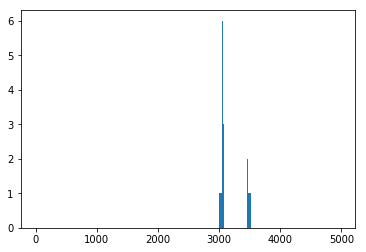

In [1222]:
#Histogram for right coordinates
bins = np.arange(0,5000,20)
plt.hist(sort_rights, bins=bins, alpha=1)
plt.show()